# QEK from A to Z

This notebook reproduces the results of the [QEK paper](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042615).

At the end, you will be able to:
1. Extract the embeddings of a molecular dataset
2. Compile these embeddings into Pulse sequences for use on a Quantum Device or an amulator.
3. Run the Pulse sequences on a Quantum Device or an emulator.


We also provide a another [machine learning tutorial](ml_tutorial.ipynb) to train an SVM with the QEK (Quantum Evolution Kernel) kernel and benchmark the performance reported in the paper.

In [1]:
from dataclasses import dataclass

import numpy as np
import torch_geometric.datasets as pyg_dataset

## Dataset preparation

As in any machine learning task, we first need to load and prepare data. QEK can work with many types of graphs, including molecular graphs. For this tutorial, we will use the PTC-FM dataset, which contains such molecular graphs.

In [2]:
# Load the original PTC-FM dataset
og_ptcfm = [data for data in pyg_dataset.TUDataset(root="dataset", name="PTC_FM")]

display("Loaded %s samples" % (len(og_ptcfm), ))

'Loaded 349 samples'

To extract machine-learning features from our dataset, we will need to configure a feature extractor. This library provides several feature extractors to either make use of a physical quantum device (QPU), or a variety of emulators.

To configure a feature extractor, we will need to give it a _compiler_, whose task is to take a list of graphs, extract embeddings and compile these embeddings to _sequences of pulses_, the format that can be executed  by either a QPU or an emulator. For this tutorial, our dataset is composed of molecule graphs, so we will use the `MoleculeGraphCompiler`:

In [3]:
import qek.data.graphs as qek_graphs

compiler = qek_graphs.MoleculeGraphCompiler()

This library provides other compilers from other formats of graphs.

# Creating and executing a feature extractor from an emulator

The easiest way to process a graph is to compile and execute it for an emulator. QEK is built on top of Pulser, which provides several emulators. The simplest of these emulators is the `QutipEmulator`, which QEK uses for the `QutipExtractor`:

In [ ]:
import qek.data.extractors as qek_extractors

# Use the Qutip Extractor.
extractor = qek_extractors.QutipExtractor(
    # Once computing is complete, data will be saved in this file.
    path="saved_data.json",
    compiler=compiler
)

# Add the graphs using the compiler we've picked previously.
extractor.add_graphs(graphs=og_ptcfm)

# We may now compile them.
compiled = extractor.compile()
display("Compiled %s sequences" % (len(compiled), ))

As you can see, the number of sequences compiled is lower than the number of samples loaded. Some of this is due to limitations within the algorithm (not all graphs can be efficiently laid out for execution on a Quantum Device), while others are due to the limitations of the emulator we target (which at the time of this writing is limited to 50 qubits).

We may now run the extraction on the emulator:

In [ ]:
# Limit the number of qubits for this run, for performance reasons.
# You can increase this value to higher number of qubits, but this
# notebook will take longer to execute and may run out of memory.
max_qubits = 5
processed_dataset = await extractor.run(max_qubits=max_qubits) # Don't forget to `await`!
display("Extracted features from %s samples"% (len(processed_dataset), ))

If you wish to extract features from more samples, feel free to increase the value of `max_qubits` above. However, you will soon run into limitations of a quantum emulator, and possibly crash this notebook. At this point, you have other options, such as using `EmuMPSExtractor` instead of `QutipExtractor`, a more recent emulator that features much better performance in most cases, or you can run the extraction on a physical QPU.

# Creating and executing a feature extractor on a physical QPU

Once you have checked that low qubit sequences provide the results you expect on an emulator, you will generally want to move to a QPU.
For this, you will need either physical access to a QPU, or an account with [PASQAL Cloud](https://docs.pasqal.cloud), which provides
you remote access to QPUs built and hosted by Pasqal. In this section, we'll see how to use the latter.

If you don't have an account, just skip to the next section!

In [ ]:
HAVE_PASQAL_ACCOUNT = False # If you have a PASQAL Cloud account, fill in the details and set this to `True`.

if HAVE_PASQAL_ACCOUNT:
    processed_dataset = []

    # Use the QPU Extractor.
    extractor = qek_extractors.QPUExtractor(
        # Once computing is complete, data will be saved in this file.
        path="saved_data.json",
        compiler = compiler,
        project_id = "XXXX", # Replace this with your project id on the PASQAL Cloud
        username = "XXX",    # Replace this with your username on PASQAL Cloud
        password = None,     # Replace this with your password on PASQAL Cloud or enter it on the command-line
    )

    # Add the graphs, exactly as above.
    extractor.add_graphs(graphs=og_ptcfm)

    # We may now compile, exactly as above.
    compiled = extractor.compile()
    display("Compiled %s sequences" % (len(compiled), ))

    # Launch the execution.
    execution = extractor.run()
    display("Work enqueued with ids %s" % (extractor.batch_ids, ))

    # ...and wait for the results.
    processed_dataset = await execution
    display("Extracted features from %s samples"% (len(processed_dataset), ))

As you can see, the process is essentially identical to executing with an emulator. Note that, as of this
writing, the waiting line to access a QPU can be very long (typically several hours).

There are two main ways to deal with this:

1. `QPUExtractor` can be attached to an ongoing job from batch ids, so that you can resume your work
    e.g. after turning off your computer.
2. Pasqal CLOUD offers access to high-performance hardware-based emulators, with dramatically
    shorter waiting lines.

See [the documentation](https://pqs.pages.pasqal.com/quantum-evolution-kernel/) for more details.

## ...or using the provided dataset

For this notebook, instead of spending hours running the simulator on your computer, we're going to skip
this step and load on we're going to cheat and load the results, which are conveniently stored in `ptcfm_processed_dataset.json`.

In [4]:
import qek.data.dataset as qek_dataset
processed_dataset = qek_dataset.load_dataset(file_path="ptcfm_processed_dataset.json")
print(f"Size of the quantum compatible dataset = {len(processed_dataset)}")

Size of the quantum compatible dataset = 279


## A look at the results

We can check the sequence for one of the samples:

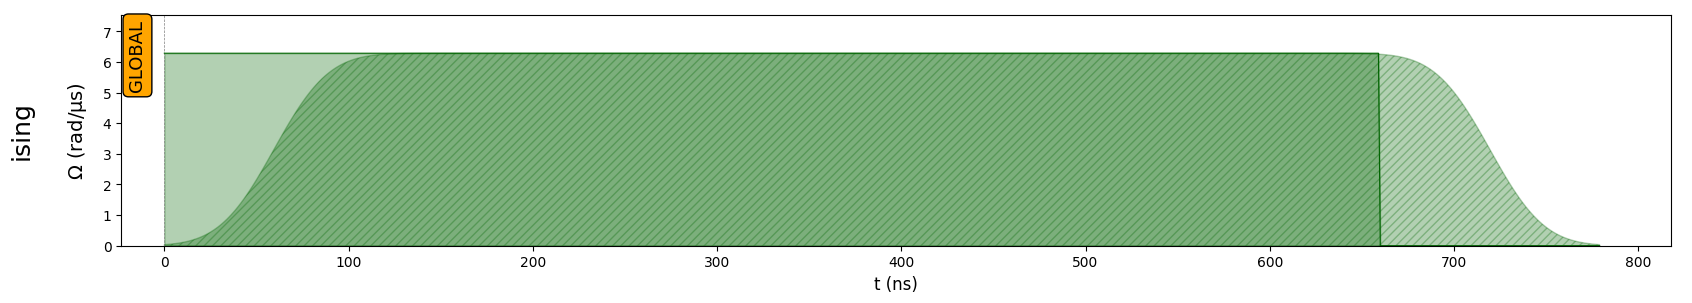

In [5]:
dataset_example = processed_dataset[64]
dataset_example.draw_sequence()

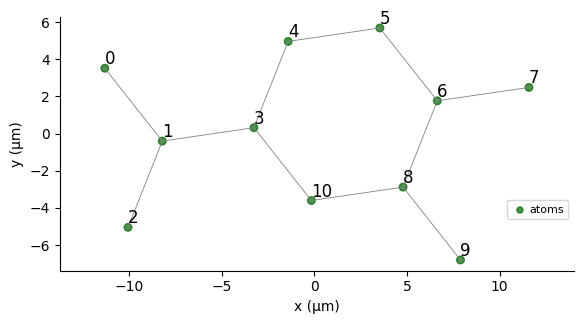

In [6]:
dataset_example.draw_register()

The results of executing the embedding on the Quantum Device are in field `state_dict`:

In [7]:
display(dataset_example.state_dict)
print(f"Total number of samples: {sum(dataset_example.state_dict.values())}")

{'00100000100': 15,
 '00100010010': 13,
 '10100100001': 7,
 '10000100000': 2,
 '10000000010': 29,
 '10000001010': 43,
 '01000000000': 20,
 '10000000000': 33,
 '10100001011': 3,
 '00001010001': 2,
 '01000001010': 9,
 '01000000100': 7,
 '00110000000': 6,
 '00100101010': 2,
 '10000000001': 13,
 '10010101100': 3,
 '01000010001': 8,
 '00000000000': 11,
 '00100000010': 21,
 '00100001100': 24,
 '01001010010': 2,
 '10000001001': 13,
 '00110001010': 15,
 '00101000010': 3,
 '00100010001': 4,
 '00110010010': 9,
 '10001001000': 4,
 '00100100010': 3,
 '00100000001': 6,
 '01000010010': 17,
 '10100001000': 8,
 '10110000100': 2,
 '10000010000': 11,
 '00010000000': 3,
 '00101001000': 2,
 '00100000000': 40,
 '00110000010': 11,
 '00100100011': 5,
 '10010000000': 17,
 '00100001010': 38,
 '10000001000': 16,
 '10001010011': 1,
 '10001010010': 5,
 '10000001100': 16,
 '10110000000': 7,
 '10010010010': 6,
 '00100001001': 19,
 '10010000010': 7,
 '00101001011': 3,
 '00101000100': 1,
 '10101001001': 5,
 '10100100

Total number of samples: 1000


This dictionary represents an approximation of the quantum state of the device for this graph after completion of the algorithm.

- each of the keys represents one possible state for the register (which represents the graph), with each qubit (which represents a single node) being in state `0` or `1`;
- the corresponding value is the number of samples observed with this specific state of the register.

In this example, for instance, we can see that the state observed most frequently is `10000001010`, with 43/1000 samples.
